In [1]:
#!/usr/bin/env python3
#@author narumeena
#@Description applying random forest classifire with cross validation 

In [3]:
import dijkstra3d
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pandas import DataFrame
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import shap
import time
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

#### Pathogenic Coding:

Below we have called in the pathogenic coding region dataframe:

In [4]:
#load the datasets 

#pathogenic varaints 

pathogenic_coding_region = pd.read_csv("pathogenic_coding_region_variants.csv")
pathogenic_coding_region.head()

/home/rob/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,114,116,118,120,122,124,126,128,130,138,141,144,147,150,153,156,159,162,167,170,173,181,182,202,203,204,207,236,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0 #Chrom      Pos Ref Alt Type  Length           AnnoType  \
0           0      1  1014143   C   T  SNV       0   CodingTranscript   
1           1      1  1014143   C   T  SNV       0         Intergenic   
2           2      1  1014143   C   T  SNV       0  RegulatoryFeature   
3           3      1  1014143   C   T  SNV       0  RegulatoryFeature   
4           4      1  1022225   G   A  SNV       0   CodingTranscript   

      Consequence  ConsScore  ... BP4  BP5  BP6  BP7 cosmic70  MCAP  REVEL  \
0     STOP_GAINED        8.0  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
1        UPSTREAM        1.0  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
2      REGULATORY        4.0  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
3      REGULATORY        4.0  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
4  NON_SYNONYMOUS        7.0  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   

  regsnp_fpr regsnp_disease regsnp_splicing_site  
0        NaN            NaN                  NaN  
1        NaN            NaN                  NaN  
2        NaN            NaN                  NaN  
3        NaN            NaN                  NaN  
4        NaN            NaN                  NaN  

[5 rows x 242 columns]

Below we have cut out columns we will not use for our model, since they do not improve the model's learning ability:

In [5]:
pathogenic_coding_region = pathogenic_coding_region.drop(columns = ['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

Below we show how many rows are in the above dataframe:

In [6]:
len(pathogenic_coding_region)

120293

For our model, we cannot have NaN values since the model cannot interpret what this means. Therefore, we must change the NaN values to 0. This process is shown below:

In [7]:
#number of null values in each column 
pd.options.display.max_rows = 400
pathogenic_coding_region.isnull().sum()

Ref                                          0
Alt                                          0
Consequence                                  0
ConsScore                                    1
ConsDetail                                   0
GC                                           0
CpG                                          0
motifECount                             113006
motifEName                              113006
motifEHIPos                             113006
motifEScoreChng                         115221
oAA                                      58337
nAA                                      58335
GeneID                                   22682
FeatureID                                    0
GeneName                                 22682
CCDS                                     44794
Intron                                  111809
Exon                                     56093
cDNApos                                  56149
relcDNApos                               56149
CDSpos       

In [8]:
#replace null value with 0 
pathogenic_coding_region = pathogenic_coding_region.fillna(0)
pd.options.display.max_rows = 400
pathogenic_coding_region.isnull().sum()

Ref                                     0
Alt                                     0
Consequence                             0
ConsScore                               0
ConsDetail                              0
GC                                      0
CpG                                     0
motifECount                             0
motifEName                              0
motifEHIPos                             0
motifEScoreChng                         0
oAA                                     0
nAA                                     0
GeneID                                  0
FeatureID                               0
GeneName                                0
CCDS                                    0
Intron                                  0
Exon                                    0
cDNApos                                 0
relcDNApos                              0
CDSpos                                  0
relCDSpos                               0
protPos                           

Below we show some statistics for all the columns that contain numerical values in our dataframe:

In [9]:
pathogenic_coding_region.describe()

ConsScore             GC            CpG    motifECount  \
count  120293.000000  120293.000000  120293.000000  120293.000000   
mean        4.952441       0.535892       0.073934       0.165005   
std         2.542593       0.112236       0.067790       1.576652   
min         0.000000       0.213000       0.000000       0.000000   
25%         2.000000       0.449000       0.027000       0.000000   
50%         6.000000       0.543000       0.053000       0.000000   
75%         7.000000       0.623000       0.093000       0.000000   
max         8.000000       0.861000       0.443000     146.000000   

         motifEHIPos  motifEScoreChng        cDNApos     relcDNApos  \
count  120293.000000    120293.000000  120293.000000  120293.000000   
mean        0.012478        -0.000882     896.384777       0.195506   
std         0.111006         0.010736    2165.319879       0.241912   
min         0.000000        -0.211000       0.000000       0.000000   
25%         0.000000         0.000000       0.000000       0.000000   
50%         0.000000         0.000000     271.000000       0.080000   
75%         0.000000         0.000000    1208.000000       0.352000   
max         1.000000         0.094000  104646.000000       0.999000   

              CDSpos      relCDSpos  ...            BP1       BP2       BP3  \
count  120293.000000  120293.000000  ...  120293.000000  120293.0  120293.0   
mean      738.713300       0.248615  ...       0.005046       0.0       0.0   
std      2101.148225       0.312611  ...       0.070856       0.0       0.0   
min         0.000000       0.000000  ...       0.000000       0.0       0.0   
25%         0.000000       0.000000  ...       0.000000       0.0       0.0   
50%        57.000000       0.032000  ...       0.000000       0.0       0.0   
75%       908.000000       0.492000  ...       0.000000       0.0       0.0   
max    104421.000000       1.000000  ...       1.000000       0.0       0.0   

                 BP4       BP5            BP6            BP7           MCAP  \
count  120293.000000  120293.0  120293.000000  120293.000000  120293.000000   
mean        0.001821       0.0       0.000565       0.000416       0.058540   
std         0.042629       0.0       0.023769       0.020383       0.210464   
min         0.000000       0.0       0.000000       0.000000       0.000000   
25%         0.000000       0.0       0.000000       0.000000       0.000000   
50%         0.000000       0.0       0.000000       0.000000       0.000000   
75%         0.000000       0.0       0.000000       0.000000       0.000000   
max         1.000000       0.0       1.000000       1.000000       0.999800   

               REVEL     regsnp_fpr  
count  120293.000000  120293.000000  
mean        0.068837       0.000079  
std         0.229521       0.002435  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         0.998000       0.253425  

[8 rows x 172 columns]

To distinguish the pathogenic variants from the benign variants, we add a column called 'category' to each. The pathogenic variants will be assigned the value '1' while the benign variants will be assigend the value '0'

In [10]:
#set categories to 1 for pathogenic ones 
# Adds colummn to end of case that is all 1's
pathogenic_coding_region['category']=1

In [11]:
# Notice how there are now 236 columns
pathogenic_coding_region.head()

Ref Alt     Consequence  ConsScore   ConsDetail     GC    CpG  motifECount  \
0   C   T     STOP_GAINED        8.0  stop_gained  0.695  0.160          0.0   
1   C   T        UPSTREAM        1.0     upstream  0.695  0.160          0.0   
2   C   T      REGULATORY        4.0   regulatory  0.695  0.160          0.0   
3   C   T      REGULATORY        4.0   regulatory  0.695  0.160          0.0   
4   G   A  NON_SYNONYMOUS        7.0     missense  0.642  0.093          0.0   

  motifEName  motifEHIPos  ...  BP5  BP6  BP7 cosmic70 MCAP REVEL regsnp_fpr  \
0          0          0.0  ...  0.0  0.0  0.0        0  0.0   0.0        0.0   
1          0          0.0  ...  0.0  0.0  0.0        0  0.0   0.0        0.0   
2          0          0.0  ...  0.0  0.0  0.0        0  0.0   0.0        0.0   
3          0          0.0  ...  0.0  0.0  0.0        0  0.0   0.0        0.0   
4          0          0.0  ...  0.0  0.0  0.0        0  0.0   0.0        0.0   

  regsnp_disease regsnp_splicing_site  category  
0              0                    0         1  
1              0                    0         1  
2              0                    0         1  
3              0                    0         1  
4              0                    0         1  

[5 rows x 236 columns]

#### Benign Coding:

Below we have called in the benign coding region dataframe:

In [12]:
benign_coding_region = pd.read_csv("benign_coding_region_variants.csv")
benign_coding_region.head()

Unnamed: 0 #Chrom      Pos Ref Alt Type  Length           AnnoType  \
0           0      1  1014042   G   A  SNV       0   CodingTranscript   
1           1      1  1014042   G   A  SNV       0         Intergenic   
2           2      1  1014042   G   A  SNV       0  RegulatoryFeature   
3           3      1  1014042   G   A  SNV       0  RegulatoryFeature   
4           4      1  1014217   C   T  SNV       0   CodingTranscript   

      Consequence  ConsScore  ... BP4  BP5  BP6  BP7 cosmic70  MCAP  REVEL  \
0  NON_SYNONYMOUS          7  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
1        UPSTREAM          1  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
2      REGULATORY          4  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
3      REGULATORY          4  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   
4      SYNONYMOUS          5  ... NaN  NaN  NaN  NaN      NaN   NaN    NaN   

  regsnp_fpr regsnp_disease regsnp_splicing_site  
0        NaN            NaN                  NaN  
1        NaN            NaN                  NaN  
2        NaN            NaN                  NaN  
3        NaN            NaN                  NaN  
4        NaN            NaN                  NaN  

[5 rows x 242 columns]

Again we cut out the columns not helpful to our model:

In [13]:
benign_coding_region = benign_coding_region.drop(columns = ['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

Below we show how many rows are in the above dataframe:

In [14]:
len(benign_coding_region)

131371

Next we will show how many values are in each column of our dataframe:

In [15]:
benign_coding_region.count()

Ref                                     131371
Alt                                     131371
Consequence                             131371
ConsScore                               131371
ConsDetail                              131371
GC                                      131371
CpG                                     131371
motifECount                              16793
motifEName                               16793
motifEHIPos                              16793
motifEScoreChng                          16750
oAA                                      23797
nAA                                      23797
GeneID                                   99144
FeatureID                               130768
GeneName                                 99144
CCDS                                     59422
Intron                                   19167
Exon                                     48504
cDNApos                                  48506
relcDNApos                               48506
CDSpos       

Below we have changed all the NaN values to 0 so that our model will work with the values:

In [16]:
benign_coding_region = benign_coding_region.fillna(0)

Next we show some statistics about the different annotations in the dataframe:

In [17]:
benign_coding_region.describe()

ConsScore             GC            CpG    motifECount  \
count  131371.000000  131371.000000  131371.000000  131371.000000   
mean        3.275281       0.565617       0.095322       0.327637   
std         1.804114       0.121624       0.085760       1.230304   
min         0.000000       0.139000       0.000000       0.000000   
25%         2.000000       0.477000       0.027000       0.000000   
50%         4.000000       0.570000       0.067000       0.000000   
75%         5.000000       0.656000       0.147000       0.000000   
max         8.000000       0.921000       0.453000      29.000000   

         motifEHIPos  motifEScoreChng        cDNApos     relcDNApos  \
count  131371.000000    131371.000000  131371.000000  131371.000000   
mean        0.036462        -0.002989     550.152606       0.137626   
std         0.187436         0.019154    2268.815793       0.242412   
min         0.000000        -0.247000       0.000000       0.000000   
25%         0.000000         0.000000       0.000000       0.000000   
50%         0.000000         0.000000       0.000000       0.000000   
75%         0.000000         0.000000     413.000000       0.187000   
max         1.000000         0.107000  188096.000000       1.000000   

              CDSpos      relCDSpos  ...            BP1       BP2       BP3  \
count  131371.000000  131371.000000  ...  131371.000000  131371.0  131371.0   
mean      259.305037       0.086637  ...       0.000731       0.0       0.0   
std      1374.532616       0.221824  ...       0.027023       0.0       0.0   
min         0.000000       0.000000  ...       0.000000       0.0       0.0   
25%         0.000000       0.000000  ...       0.000000       0.0       0.0   
50%         0.000000       0.000000  ...       0.000000       0.0       0.0   
75%         0.000000       0.000000  ...       0.000000       0.0       0.0   
max    106352.000000       1.000000  ...       1.000000       0.0       0.0   

                 BP4       BP5            BP6            BP7           MCAP  \
count  131371.000000  131371.0  131371.000000  131371.000000  131371.000000   
mean        0.018444       0.0       0.003357       0.014356       0.000364   
std         0.134551       0.0       0.057842       0.118955       0.011652   
min         0.000000       0.0       0.000000       0.000000       0.000000   
25%         0.000000       0.0       0.000000       0.000000       0.000000   
50%         0.000000       0.0       0.000000       0.000000       0.000000   
75%         0.000000       0.0       0.000000       0.000000       0.000000   
max         1.000000       0.0       1.000000       1.000000       0.923055   

               REVEL     regsnp_fpr  
count  131371.000000  131371.000000  
mean        0.001213       0.001635  
std         0.017518       0.032203  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         0.911000       1.000000  

[8 rows x 172 columns]

Just as we had to create a new column and set the pathogenic variants variants to 1, we must do the same for the benign variants setting them equal to 0:

In [18]:
#set categories to 0 for human Drive 
benign_coding_region['category']=0

Below we combine the pathogenic and benign variants:

In [19]:
#concate case and control dataset 
# If passed with join = 'inner', same dataframe will be made 
features = pd.concat([pathogenic_coding_region,benign_coding_region],axis=0, join='outer',ignore_index=True)
pd.options.display.max_rows = 8
pd.options.display.max_columns = 240
features = features.fillna(0)
features

MemoryError: Unable to allocate array with shape (166, 251664) and data type float64

Below we show the data types of the columns. This will show us which columns will be subjected to one hot encoding (object and string):

In [18]:
pd.options.display.max_rows = 240
features.dtypes == object

Ref                                      True
Alt                                      True
Consequence                              True
ConsScore                               False
ConsDetail                               True
GC                                      False
CpG                                     False
motifECount                             False
motifEName                               True
motifEHIPos                             False
motifEScoreChng                         False
oAA                                      True
nAA                                      True
GeneID                                   True
FeatureID                                True
GeneName                                 True
CCDS                                     True
Intron                                   True
Exon                                     True
cDNApos                                 False
relcDNApos                              False
CDSpos                            

Before one hot encoding the data, we want to know if we can take out any of the categorical annotation columns and any numerical columns which have no values. The reason for doing this is because if there is a categorical column in which nearly every value is different, the result of one hot encoding will be a final dataframe with thousands of columns. These columns will not improve the machine learning model since they will not lead to a grouping of pathogenic or benign. Below we find the number of unique values in each column:

In [19]:
features.nunique()

Ref                                       2975
Alt                                       1256
Consequence                                 17
ConsScore                                    9
ConsDetail                                 108
GC                                         565
CpG                                        305
motifECount                                 32
motifEName                                5483
motifEHIPos                                  2
motifEScoreChng                            264
oAA                                       2044
nAA                                        944
GeneID                                   24842
FeatureID                                43749
GeneName                                 24615
CCDS                                     13720
Intron                                    1064
Exon                                      2139
cDNApos                                   7995
relcDNApos                                1001
CDSpos       

Now we look at all the categorical values. It is a difficult decision to choose which annotations should make it. I have decided to drop columns with more than 20,000 unique values and over 200,000 values of 0. The reason for this is that quantitatively, dividing about 50,000 variants by 20,000 values gives many small groups, not providing any improvement to the machine learning model. We look at these columns below:

In [21]:
features['AAChange.ensGene'].value_counts()

0                                                                                                                                                                                                                                                                                      233647
SURF1:ENST00000615505.4:exon7:c.C445T:p.P149S,SURF1:ENST00000371974.7:exon8:c.C772T:p.P258S                                                                                                                                                                                                20
SURF1:ENST00000615505.4:exon6:c.C361T:p.R121X,SURF1:ENST00000371974.7:exon7:c.C688T:p.R230X                                                                                                                                                                                                20
SURF1:ENST00000615505.4:exon6:c.T352C:p.W118R,SURF1:ENST00000371974.7:exon7:c.T679C:p.W227R                                                   

In [22]:
features['AAChange.knownGene'].value_counts()

0                                                                                                                                                                                                                                                                                                                                                                                              233605
SURF1:uc033dkg.1:exon7:c.C445T:p.P149S,SURF1:uc004cdh.3:exon8:c.C772T:p.P258S                                                                                                                                                                                                                                                                                                                      20
SURF1:uc033dkg.1:exon6:c.C361T:p.R121X,SURF1:uc004cdh.3:exon7:c.C688T:p.R230X                                                                                                                                               

In [23]:
features['AAChange.refGene'].value_counts()

0                                                                                                   233644
UNKNOWN                                                                                                 69
SURF1:NM_001280787:exon6:c.C361T:p.R121X,SURF1:NM_003172:exon7:c.C688T:p.R230X                          20
SURF1:NM_001280787:exon7:c.C445T:p.P149S,SURF1:NM_003172:exon8:c.C772T:p.P258S                          20
SURF1:NM_001280787:exon6:c.T352C:p.W118R,SURF1:NM_003172:exon7:c.T679C:p.W227R                          20
                                                                                                     ...  
NBN:NM_002485:exon11:c.1483_1484A:p.P495Mfs*33,NBN:NM_001024688:exon12:c.1237_1238A:p.P413Mfs*33         1
FLNA:NM_001110556:exon25:c.C4294T:p.Q1432X,FLNA:NM_001456:exon25:c.C4294T:p.Q1432X                       1
COL5A1:NM_000093:exon17:c.G1855T:p.G619X,COL5A1:NM_001278074:exon17:c.G1855T:p.G619X                     1
VARS:NM_006295:exon10:c.G1325A:p.R442

In [24]:
features['GeneDetail.ensGene'].value_counts()

0                                                                                                                                                                                                                                             247976
ENST00000371974.7:exon3:c.240+1G>T;ENST00000615505.4:exon2:UTR5                                                                                                                                                                                   14
ENST00000526683.5:exon1:c.24+1G>C;ENST00000456095.6:exon1:c.24+1G>C;ENST00000349157.10:exon1:c.24+1G>C;ENST00000527197.5:exon1:c.24+1G>C                                                                                                           8
ENST00000360319.8:exon1:c.373+1G>A;ENST00000369856.7:exon1:c.292+1G>A;ENST00000422373.5:exon2:c.373+1G>A;ENST00000610817.4:exon2:c.292+1G>A;ENST00000369850.7:exon2:c.373+1G>A;ENST00000344736.8:exon1:c.373+1G>A                                  8
ENST00000277010.8:ex

In [25]:
features['GeneDetail.knownGene'].value_counts()

0                                                                                                                                                                                                                248023
uc004cdh.3:exon3:c.240+1G>T;uc033dkg.1:exon2:UTR5                                                                                                                                                                    14
uc004bsj.6:exon5:c.689+2T>C;uc011mam.4:exon5:c.143+2T>C;uc004bsk.6:exon5:c.689+2T>C                                                                                                                                   8
uc065cby.1:exon1:c.331+1G>A;uc065cbz.1:exon1:c.373+1G>A;uc065cca.1:exon1:c.292+1G>A;uc010nuu.1:exon2:c.373+1G>A;uc065ccc.1:exon2:c.292+1G>A;uc004fkk.3:exon2:c.373+1G>A;uc065cce.1:exon1:c.373+1G>A                   8
uc004cdc.5:c.-1262C>A;uc033dkf.2:c.-1262C>A;uc064wui.1:c.-1262C>A                                                                       

In [26]:
features['GeneDetail.refGene'].value_counts()

0                                                                                                                                                                          247896
NM_001280787:exon2:UTR5;NM_003172:exon3:c.240+1G>T                                                                                                                             14
NM_001271096:exon1:c.24+1G>C;NM_078480:exon1:c.24+1G>C;NM_001271099:exon1:c.24+1G>C;NM_014281:exon1:c.24+1G>C;NM_001271097:exon1:c.24+1G>C;NM_001271098:exon1:c.24+1G>C         8
NM_133640:c.-1262C>A;NM_181491:c.-1262C>A                                                                                                                                       8
NM_001456:exon2:c.373+1G>A;NM_001110556:exon2:c.373+1G>A                                                                                                                        8
                                                                                                              

Below we see that RawScore has many unique values and therefore we will cut this out of the model since it will not have much influence on the classification of benign and pathogenic variants:

In [65]:
features['RawScore'].value_counts()

 5.465256    22
 3.648538    21
 0.157392    20
 3.946918    20
 4.246230    20
             ..
 0.328167     1
 3.981685     1
 3.106677     1
 2.300014     1
-0.273499     1
Name: RawScore, Length: 110498, dtype: int64

To help us with our model, we also want to take out any columns whose values are all or very nearly all 0. We see this result in the code below:

In [27]:
features.BA1.value_counts()

0.0    251481
1.0       183
Name: BA1, dtype: int64

In [28]:
features.BP1.value_counts()

0.0    250961
1.0       703
Name: BP1, dtype: int64

In [29]:
features.BP2.value_counts()

0.0    251664
Name: BP2, dtype: int64

In [30]:
features.BP3.value_counts()

0.0    251664
Name: BP3, dtype: int64

In [31]:
features.BP4.value_counts()

0.0    249022
1.0      2642
Name: BP4, dtype: int64

In [32]:
features.BP5.value_counts()

0.0    251664
Name: BP5, dtype: int64

In [33]:
features.BP6.value_counts()

0.0    251155
1.0       509
Name: BP6, dtype: int64

In [34]:
features.BP7.value_counts()

0.0    249728
1.0      1936
Name: BP7, dtype: int64

In [35]:
features.BS1.value_counts()

0.0    251091
1.0       573
Name: BS1, dtype: int64

In [36]:
features.BS2.value_counts()

0.0    251664
Name: BS2, dtype: int64

In [37]:
features.BS3.value_counts()

0.0    251664
Name: BS3, dtype: int64

In [38]:
features.BS4.value_counts()

0.0    251664
Name: BS4, dtype: int64

In [39]:
features.GTEx_V6_gene.value_counts()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              251633
ENSG00000167103.7|ENSG00000167103.7|ENSG00000167103.7|ENSG00000167103.7|ENSG00000167103.7|ENSG00000167103.7|ENSG00000136908.13|ENSG00000136908.13|ENSG00000136908.13|ENSG00000136908.13|ENSG00000167103.7|ENSG00000136908.13|ENSG0

In [40]:
features.GTEx_V6_tissue.value_counts()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         251633
Adipose_Subcutaneous|Adipose_Visceral_Omentum|Adrenal_Gland|Artery_Aorta|Artery_Coronary|Artery_Tibial|Brain_Caudate_basal_ganglia|Brain_Cortex|Brain_Frontal_Cortex_BA9|Brain_Nucleus_

In [41]:
features.PM1.value_counts()

0.0    244515
1.0      7149
Name: PM1, dtype: int64

In [42]:
features.PM2.value_counts()

0.0    237466
1.0     14198
Name: PM2, dtype: int64

In [43]:
features.PM3.value_counts()

0.0    251664
Name: PM3, dtype: int64

In [44]:
features.PM4.value_counts()

0.0    251652
1.0        12
Name: PM4, dtype: int64

In [45]:
features.PM5.value_counts()

0.0    251456
1.0       208
Name: PM5, dtype: int64

In [46]:
features.PM6.value_counts()

0.0    251664
Name: PM6, dtype: int64

In [47]:
features.PP1.value_counts()

0.0    251664
Name: PP1, dtype: int64

In [48]:
features.PP2.value_counts()

0.0    250290
1.0      1374
Name: PP2, dtype: int64

In [49]:
features.PP3.value_counts()

0.0    241494
1.0     10170
Name: PP3, dtype: int64

In [54]:
features.PP4.value_counts()

0.0    251664
Name: PP4, dtype: int64

In [55]:
features.PP5.value_counts()

0.0    246615
1.0      5049
Name: PP5, dtype: int64

In [56]:
features.PS1.value_counts()

0.0    251649
1.0        15
Name: PS1, dtype: int64

In [57]:
features.PS2.value_counts()

0.0    251664
Name: PS2, dtype: int64

In [58]:
features.PS3.value_counts()

0.0    251664
Name: PS3, dtype: int64

In [59]:
features.PS4.value_counts()

0.0    251664
Name: PS4, dtype: int64

In [60]:
features.PVS1.value_counts()

0.0    249150
1.0      2514
Name: PVS1, dtype: int64

In [61]:
features.integrated_confidence_value.value_counts()

0.0    251563
1.0        75
3.0        13
2.0        13
Name: integrated_confidence_value, dtype: int64

In [62]:
features.targetScan.value_counts()

0.0     251389
99.0        48
95.0        42
96.0        34
89.0        23
98.0        16
81.0        13
93.0        12
82.0         9
92.0         6
78.0         6
68.0         5
54.0         4
39.0         4
97.0         4
84.0         4
71.0         4
64.0         4
30.0         4
56.0         4
69.0         3
86.0         3
88.0         3
44.0         2
63.0         2
87.0         2
83.0         2
17.0         2
66.0         2
91.0         2
90.0         1
76.0         1
74.0         1
57.0         1
33.0         1
85.0         1
Name: targetScan, dtype: int64

Below we drop all the columns not needed for the model. This will improve classification and run time:

In [18]:
pd.options.display.max_rows = 8
features = features.drop(columns = ['targetScan', 'integrated_confidence_value', 'PVS1', 'PS4', 'PS3', 'PS2',
                        'PS1', 'PP5', 'PP4', 'PP3', 'PP2', 'PP1', 'PM6', 'PM5', 'PM4', 'PM3', 'PM2',
                        'PM1', 'GTEx_V6_tissue', 'GTEx_V6_gene', 'BS4', 'BS3', 'BS2', 'BS1', 
                        'BP7', 'BP6', 'BP5', 'BP4', 'BP3', 'BP2', 'BP1', 'BA1', 'GeneDetail.refGene',
                        'GeneDetail.knownGene', 'GeneDetail.ensGene', 'AAChange.refGene', 
                        'AAChange.knownGene', 'AAChange.ensGene', 'RawScore'])
features
# Notice how we only have 197 columns now

Ref Alt  Consequence  ConsScore   ConsDetail     GC    CpG  \
0        C   T  STOP_GAINED        8.0  stop_gained  0.695  0.160   
1        C   T     UPSTREAM        1.0     upstream  0.695  0.160   
2        C   T   REGULATORY        4.0   regulatory  0.695  0.160   
3        C   T   REGULATORY        4.0   regulatory  0.695  0.160   
...     ..  ..          ...        ...          ...    ...    ...   
251660   C   A   3PRIME_UTR        2.0  3_prime_UTR  0.377  0.013   
251661   T   C   REGULATORY        4.0   regulatory  0.695  0.147   
251662   T   C     INTRONIC        2.0       intron  0.695  0.147   
251663   T   C   DOWNSTREAM        1.0   downstream  0.695  0.147   

        motifECount motifEName  motifEHIPos  motifEScoreChng oAA nAA  \
0               0.0          0          0.0              0.0   Q   *   
1               0.0          0          0.0              0.0   0   0   
2               0.0          0          0.0              0.0   0   0   
3               0.0          0          0.0              0.0   0   0   
...             ...        ...          ...              ...  ..  ..   
251660          0.0          0          0.0              0.0   0   0   
251661          0.0          0          0.0              0.0   0   0   
251662          0.0          0          0.0              0.0   0   0   
251663          0.0          0          0.0              0.0   0   0   

                 GeneID        FeatureID    GeneName         CCDS Intron Exon  \
0       ENSG00000187608  ENST00000379389       ISG15      CCDS6.1      0  2/2   
1       ENSG00000224969  ENST00000458555  AL645608.1            0      0    0   
2                     0  ENSR00000000122           0            0      0    0   
3                     0  ENSR00000344455           0            0      0    0   
...                 ...              ...         ...          ...    ...  ...   
251660  ENSG00000155961  ENST00000369454      RAB39B  CCDS14766.1      0  2/2   
251661                0  ENSR00000249743           0            0      0    0   
251662  ENSG00000185973  ENST00000334398       TMLHE  CCDS14768.1    1/7    0   
251663  ENSG00000224533  ENST00000452506   TMLHE-AS1            0      0    0   

        cDNApos  relcDNApos  CDSpos  relCDSpos  protPos  relProtPos   Domain  \
0         314.0       0.442   163.0      0.327     55.0       0.333  ndomain   
1           0.0       0.000     0.0      0.000      0.0       0.000        0   
2           0.0       0.000     0.0      0.000      0.0       0.000        0   
3           0.0       0.000     0.0      0.000      0.0       0.000        0   
...         ...         ...     ...        ...      ...         ...      ...   
251660   1549.0       0.442     0.0      0.000      0.0       0.000        0   
251661      0.0       0.000     0.0      0.000      0.0       0.000        0   
251662      0.0       0.000     0.0      0.000      0.0       0.000        0   
251663      0.0       0.000     0.0      0.000      0.0       0.000        0   

        Dst2Splice Dst2SplType  minDistTSS  minDistTSE SIFTcat  SIFTval  \
0              0.0           0         646         293       0      0.0   
1              0.0           0         646         293       0      0.0   
2              0.0           0         646         293       0      0.0   
3              0.0           0         646         293       0      0.0   
...            ...         ...         ...         ...     ...      ...   
251660         0.0           0        4393        1956       0      0.0   
251661         0.0           0         146         604       0      0.0   
251662         0.0           0         146         604       0      0.0   
251663         0.0           0         146         604       0      0.0   

       PolyPhenCat  mamPhCons  verPhCons  priPhyloP  mamPhyloP  verPhyloP  \
0                0      0.024      0.001     -0.475     -0.488     -0.090   
1                0      0.024      0.001     -0.475     -0.488     -0.090   
2

Since there is a large number of rows in the above dataframe, we will take a random sample of the data. This will allow us to run our model more quickly. The reason we can do this is because by taking a random sample, we will statistically have a high probability that our sample will represent the full population of variants we have above. Below we take a 10% sample of the full data set:

In [19]:
features =  features.sample(frac=0.1, random_state = 1)
features

Ref Alt     Consequence  ConsScore   ConsDetail     GC    CpG  \
79428     C   T      REGULATORY        4.0   regulatory  0.556  0.093   
196393    A   C      REGULATORY        4.0   regulatory  0.503  0.000   
68819   TAA   T     FRAME_SHIFT        7.0   frameshift  0.520  0.053   
134797    A   G      DOWNSTREAM        1.0   downstream  0.503  0.040   
...     ...  ..             ...        ...          ...    ...    ...   
248541    G   A  NON_SYNONYMOUS        7.0     missense  0.689  0.107   
164833    C   T        INTRONIC        2.0       intron  0.358  0.013   
108130    G   A     STOP_GAINED        8.0  stop_gained  0.404  0.040   
145177    C   T        INTRONIC        2.0       intron  0.437  0.013   

        motifECount motifEName  motifEHIPos  motifEScoreChng oAA nAA  \
79428           0.0          0          0.0              0.0   0   0   
196393          0.0          0          0.0              0.0   0   0   
68819           0.0          0          0.0              0.0   K   X   
134797          0.0          0          0.0              0.0   0   0   
...             ...        ...          ...              ...  ..  ..   
248541          0.0          0          0.0              0.0   R   Q   
164833          0.0          0          0.0              0.0   0   0   
108130          0.0          0          0.0              0.0   W   *   
145177          0.0          0          0.0              0.0   0   0   

                 GeneID        FeatureID    GeneName         CCDS Intron  \
79428                 0  ENSR00000902723           0            0      0   
196393                0  ENSR00000598790           0            0      0   
68819   ENSG00000171453  ENST00000372389      POLR1C   CCDS4901.1      0   
134797  ENSG00000271949  ENST00000370453  AC093423.3            0      0   
...                 ...              ...         ...          ...    ...   
248541  ENSG00000148362  ENST00000371620        PAXX   CCDS7020.1      0   
164833  ENSG00000126214  ENST00000452929        KLC1  CCDS45168.1  14/15   
108130  ENSG00000204217  ENST00000374580       BMPR2  CCDS33361.1      0   
145177  ENSG00000068383  ENST00000368594      INPP5A   CCDS7669.2   1/15   

        Exon  cDNApos  relcDNApos  CDSpos  relCDSpos  protPos  relProtPos  \
79428      0      0.0       0.000     0.0      0.000      0.0       0.000   
196393     0      0.0       0.000     0.0      0.000      0.0       0.000   
68819    5/9    548.0       0.404   460.0      0.442    154.0       0.445   
134797     0      0.0       0.000     0.0      0.000      0.0       0.000   
...      ...      ...         ...     ...        ...      ...         ...   
248541   4/7    391.0       0.482   365.0      0.593    122.0       0.598   
164833     0      0.0       0.000     0.0      0.000      0.0       0.000   
108130  7/13   1432.0       0.125   893.0      0.286    298.0       0.287   
145177     0      0.0       0.000     0.0      0.000      0.0       0.000   

         Domain  Dst2Splice Dst2SplType  minDistTSS  minDistTSE    SIFTcat  \
79428         0         0.0           0        7400         131          0   
196393        0         0.0           0       10235         507          0   
68819   ndomain         0.0           0         419         167          0   
134797        0         0.0           0       86728          58          0   
...         ...         ...         ...         ...         ...        ...   
248541  ndomain         0.0           0         195         226  tolerated   
164833        0         0.0           0         793          18          0   
108130  ndomain         0.0           0         275         863          0   
145177        0         0.0           0       44732      127586          0   

        SIFTval PolyPhenCat  mamPhCons  verPhCons  priPhyloP  mamPhyloP  \
79428       0.0           0      0.998      0.902     -0.509      1.317   
196393      0.0           0      0.000      0.000     -0.822     -2.147   
68819       0.0   

Below we one hot encode our combined dataframe. This takes the categorical columns and creates a matrix of them with 0s and 1s, allowing for classification by the model based on numerical values:

In [23]:
# One-hot encode the data using pandas get_dummies
# Converts categorical values into different valued matrices to identify the data numerically using 1s and 0s #
# Numerical ouput (such as FATHMM score) are untouched #
# Notice that we need to specify the dtype as float in order for our model to work below
features = pd.get_dummies(features, dtype = float)
features

KeyError: MemoryError((44208, 25166), dtype('float64'))

Below we show the data types of all the columns:

In [ ]:
pd.options.display.max_rows = 240
features.dtypes

Notice how there are much fewer columns in this dataframe than for the coding region. The reason for this must be that there were more values for annotations in the coding region. This is because one hot encoding creates a new columns for every specific value in a categorical column. Thus, there were many more unique values in the categorical columns in the coding region than in the noncoding region.

Below we create a variable for the category column which we will use later for our model:

In [50]:
labels = features['category']
labels

79428     1
196393    0
68819     1
134797    0
183091    0
         ..
243295    0
248541    0
164833    0
108130    1
145177    0
Name: category, Length: 25166, dtype: int64

Below we made our category column into a numpy array to be used in the model:

In [51]:
labels = labels.to_numpy()
labels

array([1, 0, 1, ..., 0, 1, 0])

Below we drop the category column because our machine learning model uses it only for the labels:

In [52]:
features = features.drop('category', axis = 1)
features.head()

ConsScore     GC    CpG  motifECount  motifEHIPos  motifEScoreChng  \
79428         4.0  0.556  0.093          0.0          0.0              0.0   
196393        4.0  0.503  0.000          0.0          0.0              0.0   
68819         7.0  0.520  0.053          0.0          0.0              0.0   
134797        1.0  0.503  0.040          0.0          0.0              0.0   
183091        3.0  0.768  0.307          0.0          0.0              0.0   

        cDNApos  relcDNApos  CDSpos  relCDSpos  protPos  relProtPos  \
79428       0.0       0.000     0.0      0.000      0.0       0.000   
196393      0.0       0.000     0.0      0.000      0.0       0.000   
68819     548.0       0.404   460.0      0.442    154.0       0.445   
134797      0.0       0.000     0.0      0.000      0.0       0.000   
183091    290.0       0.136     0.0      0.000      0.0       0.000   

        Dst2Splice  minDistTSS  minDistTSE  SIFTval  mamPhCons  verPhCons  \
79428          0.0        7400         131      0.0      0.998      0.902   
196393         0.0       10235         507      0.0      0.000      0.000   
68819          0.0         419         167      0.0      1.000      1.000   
134797         0.0       86728          58      0.0      0.980      0.866   
183091         0.0         289        1053      0.0      0.000      0.000   

        priPhyloP  mamPhyloP  verPhyloP  bStatistic  mirSVR-Score  mirSVR-E  \
79428      -0.509      1.317      1.607       603.0           0.0       0.0   
196393     -0.822     -2.147     -1.896       888.0           0.0       0.0   
68819       0.475      3.366      8.582       216.0           0.0       0.0   
134797     -0.314      0.058     -0.033       815.0           0.0       0.0   
183091     -0.311     -0.140     -1.488       842.0           0.0       0.0   

        mirSVR-Aln   GerpRS     GerpRSpval  tOverlapMotifs  motifDist  \
79428          0.0  1327.08  4.053600e-134             0.0        0.0   
196393         0.0     0.00   0.000000e+00             0.0        0.0   
68819          0.0    97.50   1.034680e-14             0.0        0.0   
134797         0.0     0.00   0.000000e+00             0.0        0.0   
183091         0.0     0.00   0.000000e+00             1.0       -1.0   

        EncodeH3K4me1-sum  EncodeH3K4me1-max  EncodeH3K4me2-sum  \
79428               10.98               4.54              10.30   
196393               2.74               0.80               7.17   
68819               14.10               3.21              10.50   
134797               9.50               2.23               4.12   
183091              48.82              23.32             231.73   

        EncodeH3K4me2-max  EncodeH3K4me3-sum  EncodeH3K4me3-max  \
79428                3.02               5.53               1.08   
196393               1.18               7.06               1.04   
68819                1.84              12.26               3.09   
134797               0.79               7.31               1.53   
183091              41.26             293.44              62.41   

        EncodeH3K9ac-sum  EncodeH3K9ac-max  EncodeH3K9me3-sum  \
79428              14.05              3.89               8.09   
196393              6.68              1.57              11.41   
68819              10.79              3.73               9.84   
134797              4.35              0.70              11.49   
183091            241.37             55.14               2.74   

        EncodeH3K9me3-max  EncodeH3K27ac-sum  EncodeH3K27ac-max  \
79428                3.28              11.87               3.72   
196393               2.69               3.16               1.47   
68819                3.17              11.77               2.12   
134797               1.89              11.48               2.71   
183091               0.73             213.78              46.52   

        EncodeH3K27me3-sum  EncodeH3K27me3-max  EncodeH3K36me3-sum  \
79428                 4.49                1.21               43.8

Below we create a list of the column names which we will use later to see the influence of each annotation:

In [53]:
feature_list = list(features.columns)

Below we show the number of columns in the dataframe:

In [54]:
len(features.columns)

44214

Now that all our data is numeric, we want to transform it into a numpy array to use in our model:

In [55]:
features = features.to_numpy()

## Trial Run:

Below we create and test a very small sample of our data to see if the classifier works:

In [ ]:
small_testing_sample_for_classifier = features.sample(frac=0.010, random_state = 1)
small_testing_sample_for_classifier = pd.get_dummies(features, dtype = float)

In [117]:
labels_sample = small_testing_sample_for_classifier['category']
labels_sample = labels_sample.to_numpy()
small_testing_sample_for_classifier = small_testing_sample_for_classifier.drop('category', axis = 1)
small_testing_sample_for_classifier = small_testing_sample_for_classifier.to_numpy()
train_features, test_features, train_labels, test_labels = train_test_split(small_testing_sample_for_classifier, labels_sample, test_size = 0.25, random_state = 100)
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf = 5, bootstrap = False)
model = rforest.fit(train_features, train_labels)

In [118]:
# Perform 6-fold cross validation
scores = cross_val_score(model, train_features, train_labels, cv=6, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores)

Cross-validated scores: [0.88235294 0.82352941 0.75757576 0.81818182 0.81818182 0.84375   ]


## End of Trial Run

Now we will split our data into testing and training data to later use for our model. We do a 75% training data to 25% testing data split:

In [56]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 100)

Below we show the dataframe for the training set:

In [57]:
train_features

array([[1.   , 0.53 , 0.053, ..., 1.   , 0.   , 0.   ],
       [4.   , 0.709, 0.173, ..., 1.   , 0.   , 0.   ],
       [7.   , 0.695, 0.08 , ..., 1.   , 0.   , 0.   ],
       ...,
       [1.   , 0.556, 0.067, ..., 1.   , 0.   , 0.   ],
       [4.   , 0.642, 0.04 , ..., 1.   , 0.   , 0.   ],
       [1.   , 0.424, 0.04 , ..., 1.   , 0.   , 0.   ]])

Below we show the list of training labels from our category column:

In [58]:
test_features

array([[8.   , 0.477, 0.04 , ..., 1.   , 0.   , 0.   ],
       [8.   , 0.232, 0.013, ..., 1.   , 0.   , 0.   ],
       [8.   , 0.57 , 0.08 , ..., 1.   , 0.   , 0.   ],
       ...,
       [1.   , 0.523, 0.027, ..., 1.   , 0.   , 0.   ],
       [3.   , 0.576, 0.027, ..., 1.   , 0.   , 0.   ],
       [7.   , 0.623, 0.267, ..., 1.   , 0.   , 0.   ]])

Below we show the list of testing labels from our category column:

In [59]:
train_labels

array([0, 0, 1, ..., 1, 1, 1])

Below we show the list of testing labels from our category column:

In [60]:
test_labels

array([1, 1, 1, ..., 0, 0, 1])

To see the dimensions of the arrays we are using for our model, we execute the following code:

In [61]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (18874, 44214)
Training Labels Shape: (18874,)
Testing Features Shape: (6292, 44214)
Testing Labels Shape: (6292,)


Below we run our model with all data keeping in mind all the parameters for the RandomForestClassifier function:

In [62]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=500, min_samples_split=5, min_samples_leaf = 5, bootstrap = False)
model = rforest.fit(train_features, train_labels)
#RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_split=1e-07, min_samples_leaf=5,
#            min_samples_split=5, min_weight_fraction_leaf=0.0,
#            n_estimators=500, n_jobs=2, oob_score=False, random_state=0,
#            verbose=0, warm_start=False)

Below we run cross validation on our model to see how well it performed on the training data:

In [63]:
# Perform 6-fold cross validation
scores = cross_val_score(model, train_features, train_labels, cv=6, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores)

Cross-validated scores: [0.91322314 0.90845518 0.9020979  0.89351558 0.9027027  0.9163752 ]


Below we run cross validation on our model to see how well it performs on the testing data:

In [64]:
# Perform 3-fold cross validation
scores = cross_val_score(model, test_features, test_labels, cv=3, n_jobs = 1)
#Cross-validated scores:”+
print('Cross-validated scores:', scores)

Cross-validated scores: [0.86844614 0.86361469 0.85789223]


Now we create a precision-recall curve for the classifier following the guidelines of https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/:

f1=0.911 auc=0.977 ap=0.977


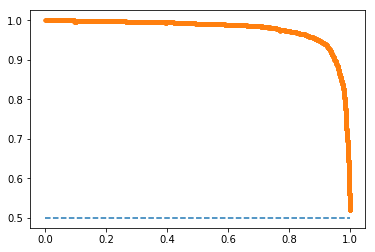

In [65]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
probs = model.predict_proba(test_features)
probs = probs[:,1]
labels_hat = model.predict(test_features)
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
f1 = f1_score(test_labels, labels_hat)
auc = auc(recall, precision)
ap = average_precision_score(test_labels, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
plt.plot([0,1], [0.5, 0.5], linestyle = '--')
plt.plot(recall, precision, marker = '.')
plt.show()

Below we show how much each annotation actually influenced the classification of the variants for this model:

In [66]:
# Get numerical feature importances
importances = list(rforest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PHRED                Importance: 0.09
Variable: mamPhyloP            Importance: 0.06
Variable: mamPhCons            Importance: 0.04
Variable: verPhCons            Importance: 0.04
Variable: verPhyloP            Importance: 0.04
Variable: ConsScore            Importance: 0.03
Variable: priPhyloP            Importance: 0.03
Variable: CDSpos               Importance: 0.02
Variable: GerpRS               Importance: 0.02
Variable: EncodetotalRNA-sum   Importance: 0.02
Variable: EncodetotalRNA-max   Importance: 0.02
Variable: cDNApos              Importance: 0.01
Variable: relCDSpos            Importance: 0.01
Variable: protPos              Importance: 0.01
Variable: relProtPos           Importance: 0.01
Variable: EncodeH3K36me3-sum   Importance: 0.01
Variable: EncodeH3K36me3-max   Importance: 0.01
Variable: EncodeH4K20me1-sum   Importance: 0.01
Variable: Grantham             Importance: 0.01
Variable: Ref_A                Importance: 0.01
Variable: Ref_T                Importanc

Variable: oAA_WLPV             Importance: 0.0
Variable: oAA_WM               Importance: 0.0
Variable: oAA_WVRV             Importance: 0.0
Variable: oAA_Y                Importance: 0.0
Variable: oAA_YD               Importance: 0.0
Variable: oAA_YED              Importance: 0.0
Variable: oAA_YF               Importance: 0.0
Variable: oAA_YL               Importance: 0.0
Variable: oAA_YN               Importance: 0.0
Variable: oAA_YSRL             Importance: 0.0
Variable: oAA_YVYLL            Importance: 0.0
Variable: nAA_*                Importance: 0.0
Variable: nAA_*GX              Importance: 0.0
Variable: nAA_*LX              Importance: 0.0
Variable: nAA_*MLX             Importance: 0.0
Variable: nAA_*VX              Importance: 0.0
Variable: nAA_-                Importance: 0.0
Variable: nAA_A                Importance: 0.0
Variable: nAA_AA               Importance: 0.0
Variable: nAA_AAAVPRX          Importance: 0.0
Variable: nAA_ACLREX           Importance: 0.0
Variable: nAA

Variable: GeneID_ENSG00000162849 Importance: 0.0
Variable: GeneID_ENSG00000162851 Importance: 0.0
Variable: GeneID_ENSG00000162852 Importance: 0.0
Variable: GeneID_ENSG00000162885 Importance: 0.0
Variable: GeneID_ENSG00000162910 Importance: 0.0
Variable: GeneID_ENSG00000162927 Importance: 0.0
Variable: GeneID_ENSG00000162928 Importance: 0.0
Variable: GeneID_ENSG00000162981 Importance: 0.0
Variable: GeneID_ENSG00000162994 Importance: 0.0
Variable: GeneID_ENSG00000163013 Importance: 0.0
Variable: GeneID_ENSG00000163016 Importance: 0.0
Variable: GeneID_ENSG00000163017 Importance: 0.0
Variable: GeneID_ENSG00000163029 Importance: 0.0
Variable: GeneID_ENSG00000163050 Importance: 0.0
Variable: GeneID_ENSG00000163069 Importance: 0.0
Variable: GeneID_ENSG00000163071 Importance: 0.0
Variable: GeneID_ENSG00000163082 Importance: 0.0
Variable: GeneID_ENSG00000163093 Importance: 0.0
Variable: GeneID_ENSG00000163110 Importance: 0.0
Variable: GeneID_ENSG00000163131 Importance: 0.0
Variable: GeneID_ENS

Variable: GeneID_ENSG00000260436 Importance: 0.0
Variable: GeneID_ENSG00000260442 Importance: 0.0
Variable: GeneID_ENSG00000260459 Importance: 0.0
Variable: GeneID_ENSG00000260465 Importance: 0.0
Variable: GeneID_ENSG00000260466 Importance: 0.0
Variable: GeneID_ENSG00000260468 Importance: 0.0
Variable: GeneID_ENSG00000260537 Importance: 0.0
Variable: GeneID_ENSG00000260542 Importance: 0.0
Variable: GeneID_ENSG00000260548 Importance: 0.0
Variable: GeneID_ENSG00000260552 Importance: 0.0
Variable: GeneID_ENSG00000260568 Importance: 0.0
Variable: GeneID_ENSG00000260589 Importance: 0.0
Variable: GeneID_ENSG00000260592 Importance: 0.0
Variable: GeneID_ENSG00000260597 Importance: 0.0
Variable: GeneID_ENSG00000260608 Importance: 0.0
Variable: GeneID_ENSG00000260616 Importance: 0.0
Variable: GeneID_ENSG00000260619 Importance: 0.0
Variable: GeneID_ENSG00000260648 Importance: 0.0
Variable: GeneID_ENSG00000260689 Importance: 0.0
Variable: GeneID_ENSG00000260719 Importance: 0.0
Variable: GeneID_ENS

Variable: FeatureID_ENSR00000530518 Importance: 0.0
Variable: FeatureID_ENSR00000531245 Importance: 0.0
Variable: FeatureID_ENSR00000531774 Importance: 0.0
Variable: FeatureID_ENSR00000532947 Importance: 0.0
Variable: FeatureID_ENSR00000533511 Importance: 0.0
Variable: FeatureID_ENSR00000533672 Importance: 0.0
Variable: FeatureID_ENSR00000533976 Importance: 0.0
Variable: FeatureID_ENSR00000533993 Importance: 0.0
Variable: FeatureID_ENSR00000534054 Importance: 0.0
Variable: FeatureID_ENSR00000534612 Importance: 0.0
Variable: FeatureID_ENSR00000535074 Importance: 0.0
Variable: FeatureID_ENSR00000535090 Importance: 0.0
Variable: FeatureID_ENSR00000535096 Importance: 0.0
Variable: FeatureID_ENSR00000535327 Importance: 0.0
Variable: FeatureID_ENSR00000535381 Importance: 0.0
Variable: FeatureID_ENSR00000535383 Importance: 0.0
Variable: FeatureID_ENSR00000535412 Importance: 0.0
Variable: FeatureID_ENSR00000535443 Importance: 0.0
Variable: FeatureID_ENSR00000535474 Importance: 0.0
Variable: Fe

Variable: FeatureID_ENST00000339365 Importance: 0.0
Variable: FeatureID_ENST00000339399 Importance: 0.0
Variable: FeatureID_ENST00000339463 Importance: 0.0
Variable: FeatureID_ENST00000339464 Importance: 0.0
Variable: FeatureID_ENST00000339465 Importance: 0.0
Variable: FeatureID_ENST00000339507 Importance: 0.0
Variable: FeatureID_ENST00000339594 Importance: 0.0
Variable: FeatureID_ENST00000339618 Importance: 0.0
Variable: FeatureID_ENST00000339659 Importance: 0.0
Variable: FeatureID_ENST00000339664 Importance: 0.0
Variable: FeatureID_ENST00000339697 Importance: 0.0
Variable: FeatureID_ENST00000339728 Importance: 0.0
Variable: FeatureID_ENST00000339859 Importance: 0.0
Variable: FeatureID_ENST00000339876 Importance: 0.0
Variable: FeatureID_ENST00000339950 Importance: 0.0
Variable: FeatureID_ENST00000340020 Importance: 0.0
Variable: FeatureID_ENST00000340096 Importance: 0.0
Variable: FeatureID_ENST00000340124 Importance: 0.0
Variable: FeatureID_ENST00000340126 Importance: 0.0
Variable: Fe

Variable: FeatureID_ENST00000521913 Importance: 0.0
Variable: FeatureID_ENST00000521945 Importance: 0.0
Variable: FeatureID_ENST00000522077 Importance: 0.0
Variable: FeatureID_ENST00000522083 Importance: 0.0
Variable: FeatureID_ENST00000522190 Importance: 0.0
Variable: FeatureID_ENST00000522208 Importance: 0.0
Variable: FeatureID_ENST00000522306 Importance: 0.0
Variable: FeatureID_ENST00000522436 Importance: 0.0
Variable: FeatureID_ENST00000522622 Importance: 0.0
Variable: FeatureID_ENST00000522728 Importance: 0.0
Variable: FeatureID_ENST00000522817 Importance: 0.0
Variable: FeatureID_ENST00000522880 Importance: 0.0
Variable: FeatureID_ENST00000522917 Importance: 0.0
Variable: FeatureID_ENST00000522943 Importance: 0.0
Variable: FeatureID_ENST00000523030 Importance: 0.0
Variable: FeatureID_ENST00000523038 Importance: 0.0
Variable: FeatureID_ENST00000523081 Importance: 0.0
Variable: FeatureID_ENST00000523211 Importance: 0.0
Variable: FeatureID_ENST00000523268 Importance: 0.0
Variable: Fe

Variable: GeneName_AL020996.2  Importance: 0.0
Variable: GeneName_AL021068.2  Importance: 0.0
Variable: GeneName_AL021155.2  Importance: 0.0
Variable: GeneName_AL021331.1  Importance: 0.0
Variable: GeneName_AL021707.1  Importance: 0.0
Variable: GeneName_AL021707.5  Importance: 0.0
Variable: GeneName_AL021707.6  Importance: 0.0
Variable: GeneName_AL021707.7  Importance: 0.0
Variable: GeneName_AL021707.8  Importance: 0.0
Variable: GeneName_AL021878.2  Importance: 0.0
Variable: GeneName_AL021920.1  Importance: 0.0
Variable: GeneName_AL021939.1  Importance: 0.0
Variable: GeneName_AL022069.2  Importance: 0.0
Variable: GeneName_AL022238.4  Importance: 0.0
Variable: GeneName_AL022318.4  Importance: 0.0
Variable: GeneName_AL022322.2  Importance: 0.0
Variable: GeneName_AL022323.3  Importance: 0.0
Variable: GeneName_AL022326.2  Importance: 0.0
Variable: GeneName_AL022328.2  Importance: 0.0
Variable: GeneName_AL022332.2  Importance: 0.0
Variable: GeneName_AL022341.1  Importance: 0.0
Variable: Gen

Variable: GeneName_OTOP1       Importance: 0.0
Variable: GeneName_OTOP2       Importance: 0.0
Variable: GeneName_OTUB1       Importance: 0.0
Variable: GeneName_OTUD6B      Importance: 0.0
Variable: GeneName_OTUD6B-AS1  Importance: 0.0
Variable: GeneName_OTUD7A      Importance: 0.0
Variable: GeneName_OTX1        Importance: 0.0
Variable: GeneName_OVAAL       Importance: 0.0
Variable: GeneName_OVOL3       Importance: 0.0
Variable: GeneName_OXA1L       Importance: 0.0
Variable: GeneName_OXCT1       Importance: 0.0
Variable: GeneName_P2RX5-TAX1BP3 Importance: 0.0
Variable: GeneName_P2RX6P      Importance: 0.0
Variable: GeneName_P2RY11      Importance: 0.0
Variable: GeneName_P2RY13      Importance: 0.0
Variable: GeneName_P2RY2       Importance: 0.0
Variable: GeneName_P3H1        Importance: 0.0
Variable: GeneName_P3H2        Importance: 0.0
Variable: GeneName_P3H4        Importance: 0.0
Variable: GeneName_PA2G4       Importance: 0.0
Variable: GeneName_PA2G4P1     Importance: 0.0
Variable: G

Variable: CCDS_CCDS1834.1      Importance: 0.0
Variable: CCDS_CCDS1836.1      Importance: 0.0
Variable: CCDS_CCDS1838.1      Importance: 0.0
Variable: CCDS_CCDS184.1       Importance: 0.0
Variable: CCDS_CCDS1846.1      Importance: 0.0
Variable: CCDS_CCDS1848.1      Importance: 0.0
Variable: CCDS_CCDS1853.1      Importance: 0.0
Variable: CCDS_CCDS1856.1      Importance: 0.0
Variable: CCDS_CCDS1857.1      Importance: 0.0
Variable: CCDS_CCDS1859.1      Importance: 0.0
Variable: CCDS_CCDS1862.1      Importance: 0.0
Variable: CCDS_CCDS1865.1      Importance: 0.0
Variable: CCDS_CCDS1866.1      Importance: 0.0
Variable: CCDS_CCDS1872.1      Importance: 0.0
Variable: CCDS_CCDS1873.1      Importance: 0.0
Variable: CCDS_CCDS1879.1      Importance: 0.0
Variable: CCDS_CCDS1880.2      Importance: 0.0
Variable: CCDS_CCDS1885.1      Importance: 0.0
Variable: CCDS_CCDS189.1       Importance: 0.0
Variable: CCDS_CCDS1892.1      Importance: 0.0
Variable: CCDS_CCDS1895.1      Importance: 0.0
Variable: CCD

Variable: Intron_4/5           Importance: 0.0
Variable: Intron_4/6           Importance: 0.0
Variable: Intron_4/7           Importance: 0.0
Variable: Intron_4/70          Importance: 0.0
Variable: Intron_4/8           Importance: 0.0
Variable: Intron_4/9           Importance: 0.0
Variable: Intron_40/40         Importance: 0.0
Variable: Intron_40/41         Importance: 0.0
Variable: Intron_43/46         Importance: 0.0
Variable: Intron_44/55         Importance: 0.0
Variable: Intron_46/50         Importance: 0.0
Variable: Intron_47/47         Importance: 0.0
Variable: Intron_47/50         Importance: 0.0
Variable: Intron_47/53         Importance: 0.0
Variable: Intron_47/80         Importance: 0.0
Variable: Intron_48/56         Importance: 0.0
Variable: Intron_48/60         Importance: 0.0
Variable: Intron_5-6/18        Importance: 0.0
Variable: Intron_5/10          Importance: 0.0
Variable: Intron_5/11          Importance: 0.0
Variable: Intron_5/12          Importance: 0.0
Variable: Int

Variable: MutationTaster_pred.1_P Importance: 0.0
Variable: MutationAssessor_pred.1_0 Importance: 0.0
Variable: MutationAssessor_pred.1_H Importance: 0.0
Variable: MutationAssessor_pred.1_L Importance: 0.0
Variable: MutationAssessor_pred.1_M Importance: 0.0
Variable: MutationAssessor_pred.1_N Importance: 0.0
Variable: FATHMM_pred.1_0      Importance: 0.0
Variable: FATHMM_pred.1_D      Importance: 0.0
Variable: FATHMM_pred.1_T      Importance: 0.0
Variable: PROVEAN_pred_0       Importance: 0.0
Variable: PROVEAN_pred_D       Importance: 0.0
Variable: PROVEAN_pred_N       Importance: 0.0
Variable: MetaSVM_pred_0       Importance: 0.0
Variable: MetaSVM_pred_D       Importance: 0.0
Variable: MetaSVM_pred_T       Importance: 0.0
Variable: MetaLR_pred_0        Importance: 0.0
Variable: MetaLR_pred_D        Importance: 0.0
Variable: MetaLR_pred_T        Importance: 0.0
Variable: M-CAP_pred_0         Importance: 0.0
Variable: M-CAP_pred_D         Importance: 0.0
Variable: M-CAP_pred_T         I

Below we make a list of the annotation names corresponding to the importances in descending order:

In [67]:
feature_importances_list = [x for x,_ in feature_importances]
feature_importances_list

['PHRED',
 'mamPhyloP',
 'mamPhCons',
 'verPhCons',
 'verPhyloP',
 'ConsScore',
 'priPhyloP',
 'CDSpos',
 'GerpRS',
 'EncodetotalRNA-sum',
 'EncodetotalRNA-max',
 'cDNApos',
 'relCDSpos',
 'protPos',
 'relProtPos',
 'EncodeH3K36me3-sum',
 'EncodeH3K36me3-max',
 'EncodeH4K20me1-sum',
 'Grantham',
 'Ref_A',
 'Ref_T',
 'Consequence_FRAME_SHIFT',
 'Consequence_SYNONYMOUS',
 'ConsDetail_frameshift',
 'ConsDetail_stop_gained',
 'ConsDetail_synonymous',
 'oAA_0',
 'nAA_0',
 'nAA_X',
 'Domain_0',
 'Domain_ndomain',
 'SIFTcat_0',
 'SIFTcat_deleterious',
 'PolyPhenCat_0',
 'PolyPhenCat_probably_damaging',
 'GC',
 'CpG',
 'motifECount',
 'motifEHIPos',
 'motifEScoreChng',
 'relcDNApos',
 'Dst2Splice',
 'minDistTSS',
 'minDistTSE',
 'SIFTval',
 'bStatistic',
 'mirSVR-Score',
 'mirSVR-E',
 'mirSVR-Aln',
 'GerpRSpval',
 'tOverlapMotifs',
 'motifDist',
 'EncodeH3K4me1-sum',
 'EncodeH3K4me1-max',
 'EncodeH3K4me2-sum',
 'EncodeH3K4me2-max',
 'EncodeH3K4me3-sum',
 'EncodeH3K4me3-max',
 'EncodeH3K9ac-sum',
 'EncodeH3K9ac-max',
 'EncodeH3K9me3-sum',
 'EncodeH3K9me3-max',
 'EncodeH3K27ac-sum',
 'EncodeH3K27ac-max',
 'EncodeH3K27me3-sum',
 'EncodeH3K27me3-max',
 'EncodeH3K79me2-sum',
 'EncodeH3K79me2-max',
 'EncodeH4K20me1-max',
 'EncodeH2AFZ-sum',
 'EncodeH2AFZ-max',
 'EncodeDNase-sum',
 'EncodeDNase-max',
 'Dist2Mutation',
 'Freq100bp',
 'Rare100bp',
 'Sngl100bp',
 'Freq1000bp',
 'Rare1000bp',
 'Sngl1000bp',
 'Freq10000bp',
 'Rare10000bp',
 'Sngl10000bp',
 'dbscSNV-ada_score',
 'dbscSNV-rf_score',
 'RemapOverlapTF',
 'RemapOverlapCL',
 'SIFT_score',
 'Polyphen2_HDIV_score',
 'Polyphen2_HVAR_score',
 'LRT_score',
 'MutationTaster_score',
 'MutationAssessor_score',
 'FATHMM_score',
 'RadialSVM_score',
 'LR_score',
 'VEST3_score',
 'CADD_raw',
 'CADD_phred',
 'GERP++_RS',
 'phyloP46way_placental',
 'phyloP100way_vertebrate',
 'SiPhy_29way_logOdds',
 'SIFT_score.1',
 'SIFT_converted_rankscore',
 'Polyphen2_HDIV_score.1',
 'Polyphen2_HDIV_rankscore',
 'Polyphen2_HVAR_score.1',
 'Polyphen2_HVAR_rankscore',
 'LRT_score.1',
 'LRT_converted_rankscore',
 'MutationTaster_score.1',
 'MutationTaster_converted_rankscore',
 'MutationAssessor_score.1',
 'MutationAssessor_score_rankscore',
 'FATHMM_score.1',
 'FATHMM_converted_rankscore',
 'PROVEAN_score',
 'PROVEAN_converted_rankscore',
 'VEST3_score.1',
 'VEST3_rankscore',
 'MetaSVM_score',
 'MetaSVM_rankscore',
 'MetaLR_score',
 'MetaLR_rankscore',
 'M-CAP_score',
 'M-CAP_rankscore',
 'CADD_raw.1',
 'CADD_raw_rankscore',
 'CADD_phred.1',
 'DANN_score',
 'DANN_rankscore',
 'fathmm-MKL_coding_score',
 'fathmm-MKL_coding_rankscore',
 'Eigen-raw',
 'Eigen-PC-raw',
 'GenoCanyon_score',
 'GenoCanyon_score_rankscore',
 'integrated_fitCons_score',
 'integrated_fitCons_score_rankscore',
 'GERP++_RS.1',
 'GERP++_RS_rankscore',
 'phyloP100way_vertebrate.1',
 'phyloP100way_vertebrate_rankscore',
 'phyloP20way_mammalian',
 'phyloP20way_mammalian_rankscore',
 'phastCons100way_vertebrate',
 'phastCons100way_vertebrate_rankscore',
 'phastCons20way_mammalian',
 'phastCons20way_mammalian_rankscore',
 'SiPhy_29way_logOdds.1',
 'SiPhy_29way_logOdds_rankscore',
 'dbscSNV_ADA_SCORE',
 'dbscSNV_RF_SCORE',
 'MCAP',
 'REVEL',
 'regsnp_fpr',
 'Ref_AAAAAC',
 'Ref_AAAAC',
 'Ref_AAAAG',
 'Ref_AAAAGAGAGTGGAAG',
 'Ref_AAAAGGATACT',
 'Ref_AAAC',
 'Ref_AAAG',
 'Ref_AAAGAAAAAAAAATATTTTTTATTTCAGTTAATCGGGAAGCTTTGTCAGAGCCCTACCCATAAGGAGAAGAGACAACAGCTGCCTTTATTCTTGTTGGTTTGCTTTGCAATCCGCTCCGTGTAAAGTCAGCTAACTCTCTCGGTCACGGGCGTCCGGCTGTCCACAGGCTCCTCTCTGTTTGGCCTTGGCATGGAGGATGAAACAATGTCTTTGCGCTCTCCCTCCCCTCGGTGTTTGTACTTTTCTGCGGCCGTGGCGGCGGTGGCAACCGCGGGCTGAGTCTTAGCTGGCTCCTTGGGGCAGCCGTCGCTCTCCAGTGAGCCTCCTCTGGGCATCTTCTCCTCTTTGCAGACGCTGCTGCTCAAGTCCTGGGGCTCAGGGGGGCTGGTGGGGTCCTCGGAGCTCTCGGGCTCAGGTGGAGGTGGGGGCAGGGGTGGGAGCAGTGGCACGGGGGCCTTTGGGGACTCTGAGTGGTGGTGATGGTGGTGGTGCTCCTTCTTGGGGGGTGAGGAGGCGCTGCTGCTGCGCCCCTTGGGGCTGCTCTCCTTGCTTTTCCGCCCAGGGCTCTTACAGGTCTTCAGTCCTTTCCCGCTCTTCTCACCGAGGGTGGACACCAGCAGGGGCTTCACCACTTCCTTGACCTCGATGCTGACCGTCTCCCGGGTCTTGCGCTTCTTGATGGGGAGTAC

Below we make a list of the importances of the annotations in descending order. NOTICE HOW IN THIS DEFINITION OF feature_importances, WE DID NOT ROUND THE IMPORTANCE AS WE DID ABOVE:

In [68]:
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances_values = [y for _,y in feature_importances]
feature_importances_values

[0.09390413029625624,
 0.062281709837749354,
 0.04327240706850947,
 0.0409230143903146,
 0.0376051036863046,
 0.03291590139004481,
 0.03284906368777393,
 0.021680147651637893,
 0.017446812897718468,
 0.01621040066190963,
 0.015863434353989837,
 0.013789231885206046,
 0.013043881931672835,
 0.012561746194046925,
 0.012173339041825278,
 0.011260724813573238,
 0.011148443227371818,
 0.011023846368818252,
 0.010313314339961027,
 0.01011387781652787,
 0.009857954492657655,
 0.009351246409965,
 0.008919987436753365,
 0.00833138842641244,
 0.007971187598595246,
 0.007353963339854445,
 0.006744955310533506,
 0.006713710290125609,
 0.00564597036255241,
 0.005635131392792487,
 0.0053193920023562186,
 0.005261545415731439,
 0.00521579139950964,
 0.005137602444936862,
 0.00511905092800703,
 0.004955136923772205,
 0.004772241634605458,
 0.004665045759757336,
 0.0042600276385670885,
 0.004120176332147125,
 0.004110653195733566,
 0.004023423340388789,
 0.0039537880281442055,
 0.0038137516406594745,
 0.0037680813165742225,
 0.0037596303704985584,
 0.0037105052591329428,
 0.0035786329640415267,
 0.0035745548510027762,
 0.0034787814016980423,
 0.003308497980033559,
 0.003152011327503577,
 0.003090597329114222,
 0.003075472054964145,
 0.0030663276579289606,
 0.003012463401140485,
 0.003012266143052943,
 0.0029810495982900086,
 0.0029541274570479667,
 0.0029318131291883906,
 0.002916025779583124,
 0.002888075616317817,
 0.002887809033095072,
 0.002858207941350264,
 0.0027732568441886448,
 0.002711727183885611,
 0.002690806878946769,
 0.0026789016469719357,
 0.002670739602739711,
 0.002657916144413626,
 0.002637931992812223,
 0.0026342889652539035,
 0.002522124284131611,
 0.0025072240806125355,
 0.002498126123200193,
 0.00248062410789259,
 0.0024344579047003412,
 0.0024189837965979265,
 0.002386375100046201,
 0.0023565308406348602,
 0.002321748069937328,
 0.0022813124680492194,
 0.002270850955452047,
 0.0022599323257602223,
 0.0021944078147790986,
 0.002191861047305384,
 0.002186901774721448,
 0.0021775183469338838,
 0.0021752193335678144,
 0.00214276115628129,
 0.002136449301628396,
 0.002108844600923555,
 0.0020727490198787332,
 0.0020627254749013063,
 0.0020264953439379295,
 0.002024046623201888,
 0.002015955733455575,
 0.001985718485410988,
 0.0019743360934236153,
 0.0019268201787282742,
 0.001921433941582612,
 0.001918599339784877,
 0.0018204811008405081,
 0.0017960801112152237,
 0.0017746762457941344,
 0.00176333374330304,
 0.0017514162045370802,
 0.0017442342061352064,
 0.001678595362347221,
 0.0016690931893213895,
 0.0016395937665847713,
 0.0016088738360319095,
 0.0015874008247657076,
 0.0015862219525575182,
 0.0015806654061218486,
 0.0015684111736673895,
 0.0015499925939807427,
 0.0014925939054292623,
 0.001491944519629688,
 0.0014811738296200787,
 0.0014504752931423191,
 0.001446453250594679,
 0.0014420713657653254,
 0.0014355890547570276,
 0.0014269495040933444,
 0.0014147212662616844,
 0.001377406584950932,
 0.0013749055875109917,
 0.0013742762956567242,
 0.0013716897988181515,
 0.0013445717841358662,
 0.0013347986768878996,
 0.0013238842716923084,
 0.0012999461798296767,
 0.001251772465016478,
 0.0012463370329457032,
 0.0012391850332039579,
 0.0012359203752485123,
 0.00122085123100888,
 0.0012187786850665666,
 0.001213739641872492,
 0.0012103850227425097,
 0.001183359498688222,
 0.0011715749181820943,
 0.0011696377752546602,
 0.0011603470563860223,
 0.0011594999131117221,
 0.001151656707338596,
 0.001130095005324718,
 0.0011299958681489724,
 0.0011273067738792161,
 0.0011256873916602398,
 0.0011076419883322437,
 0.0010989716735397028,
 0.0010842030098987003,
 0.001069700901016814,
 0.0010633553503423933,
 0.0010613895790048998,
 0.0010610931432265957,
 0.0010587140863482563,
 0.0010488369069468052,
 0.001034844754033379,
 0.0010203147655654095,
 0.0009999993561539092,
 0.0009922202501929894,
 0.0009638378153282032,
 0.0009592123877900506,
 0.000957970463530183,
 0.0009519504572398702,
 0.0009217571273685915,
 0.0009166467145097886,
 0

Below we plot a graph of the first 15 features from the list above:

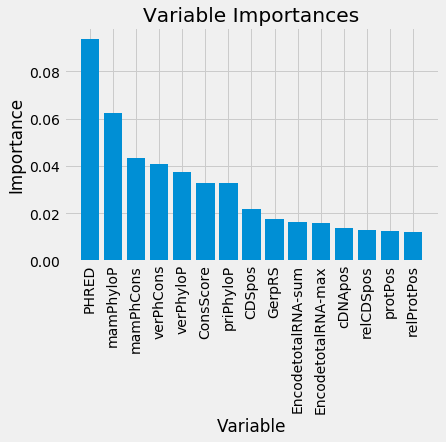

In [69]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(feature_importances_values[:15])))
# Make a bar chart
plt.bar(x_values, feature_importances_values[:15], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_importances_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we plot the first 300 feature importances. The graph below shows how influential each figure is to the model. As we will see, there are only a few features that impact the model followed by a steep dropoff of the remaining features. For the future, it is possible to only keep the features who show a high importance value and drop the rest. Below we show how many features, out of the 44,045 total features, had a large impact on the classification of variants:

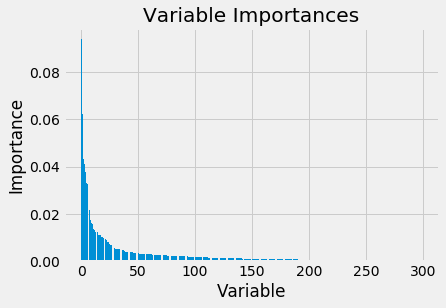

In [70]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values[:300])))
plt.bar(x_values, feature_importances_values[:300], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

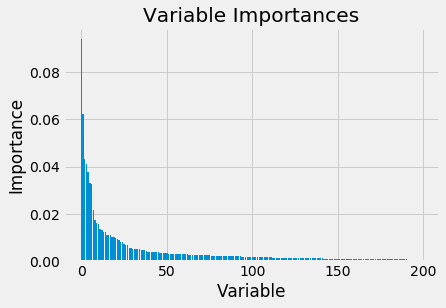

In [71]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values[:200])))
plt.bar(x_values, feature_importances_values[:200], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Below we see the final graph of importances. This means that if we take only the first 190 features for our model above in the list, our model will show very similar outputs. We will test this further on:

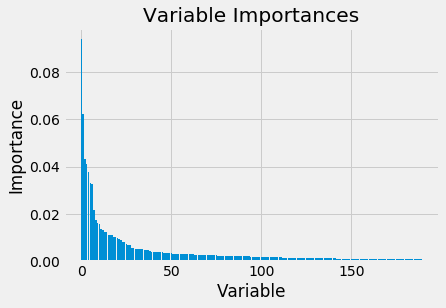

In [72]:
plt.style.use('fivethirtyeight')
x_values = list(range(len(feature_importances_values[:190])))
plt.bar(x_values, feature_importances_values[:190], orientation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');